# Stackoverflow Q/A 

StackOverflow is an online Q/A site where users can ask and answer questions, tag and edit questions, vote on the quality of answers, and post comments on individual questions and answers.

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import re
from wordcloud import WordCloud
import operator
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.8)


In [2]:
# connect to SQL database
dbfile = '/Users/ando/andry/ML/projects/stackoverflow/astronomy/db/stackoverflowASTRO.db'
conn = sqlite3.connect(dbfile)
c = conn.cursor()

# Explore the data

Number of Users: 11216
Number of Questions: 4704
Number of Answers: 6982
Number of questions with accepted answer: 2477




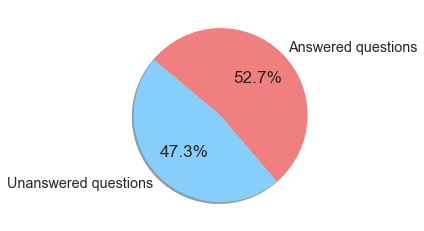

In [3]:
# Total number of users 
c.execute("SELECT COUNT(*) FROM users;")
N_Users = c.fetchall()[0][0]
print("Number of Users: "+str(N_Users))

# Total number of questions
c.execute("SELECT COUNT(*) FROM posts WHERE PostTypeId = 1;")
N_Questions = c.fetchall()[0][0]
print("Number of Questions: "+str(N_Questions))

# Total number of answers
c.execute("SELECT COUNT(*) FROM posts WHERE PostTypeId = 2;")
N_Answers = c.fetchall()[0][0]
print("Number of Answers: "+str(N_Answers))

# Total number questions with accepted answer
c.execute("SELECT COUNT(AcceptedAnswerId) FROM posts;")
N_AcceptedAnswers = c.fetchall()[0][0]
print("Number of questions with accepted answer: "+str(N_AcceptedAnswers))

labels = ['Unanswered questions','Answered questions']
values = [N_Questions-N_AcceptedAnswers,N_AcceptedAnswers]
colors = ['lightskyblue','lightcoral']
plt.axis("equal")
plt.pie(values, labels =labels, colors=colors, autopct="%1.1f%%",shadow=True, startangle=140)
print("\n")

## QUESTIONS with maximum number of answers


10 answers for 
    "Why don't astronomers use meters to measure astronomical distances?"

9 answers for 
    "What's the largest non-spherical astronomical object in the universe?"




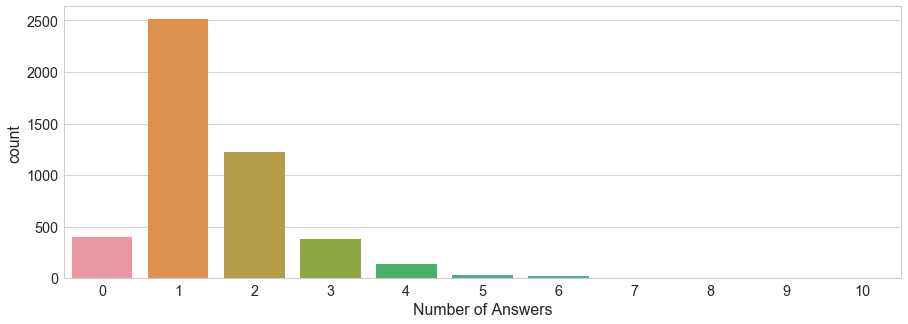

In [4]:
query = "SELECT id, AnswerCount, Title FROM posts WHERE PostTypeID = 1 ORDER BY 2 DESC"

answercount_df = pd.read_sql_query(query,conn)

for i in [0,1]: print("\n"+str(answercount_df['AnswerCount'][i])+" answers for \n    \""+str(answercount_df['Title'][i])+"\"")
fig, ax = plt.subplots(figsize=(15.0,5.0))   
sns.countplot(x='AnswerCount',data=answercount_df)
ax.set_xlabel("Number of Answers")
print("\n")

## QUESTIONS with maximum number of comments

In [5]:
query = "SELECT id, CommentCount, Title FROM posts where PostTypeID = 1 ORDER BY 2 DESC"
c.execute(query)
answergg = c.fetchall()
for i in [0,1]: print("\n"+str(answergg[i][1])+" comments for \n \""+str(answergg[i][2])+"\"")


26 comments for 
 "A quick (elementary) check on arsecond conversion to sky distance in parsecs"

19 comments for 
 "How does gravity really work"


## Most viewed posts

In [6]:
query = "SELECT title, viewcount FROM posts ORDER BY viewcount DESC LIMIT 2;"
c.execute(query)
answergg = c.fetchall()
for i in [0,1]: print("\n"+str(answergg[i][1])+" viewed \n \""+str(answergg[i][0])+"\"")


52598 viewed 
 "Star like light moving in the sky, what could it be?"

42974 viewed 
 "How much magnification is needed to see planets of solar system?"


## Most voted questions and answers

In [7]:
query = "SELECT id, score, Title FROM posts WHERE posttypeid = 1 ORDER BY score DESC LIMIT 2;"
c.execute(query)
answergg = c.fetchall()
for i in [0,1]: print("\n"+str(answergg[i][1])+" Votes for the question \n  - "+str(answergg[i][2])+"\"")

query = "SELECT id, score FROM posts WHERE posttypeid = 2 ORDER BY score DESC LIMIT 2;"
c.execute(query)
answergg = c.fetchall()
for i in [0,1]: print("\n"+str(answergg[i][1])+" Votes for Answer Id \""+str(answergg[i][0])+"\"")


89 Votes for the question 
  - How loud would the Sun be?"

66 Votes for the question 
  - Does the Sun rotate?"

89 Votes for Answer Id "16313"

72 Votes for Answer Id "2363"


## Users reputation

In [8]:
sql_query ="SELECT id, DisplayName, reputation, Location FROM users;"
users_rep = pd.read_sql_query(sql_query, conn)

print('\nSum of Users reputation: '+str(users_rep['Reputation'].sum()))
print('\nAverage reputation: '+str(users_rep['Reputation'].sum()/len(users_rep)))

users_df = users_rep[['DisplayName', 'Reputation']].sort_values(by='Reputation', ascending=False)
ff = users_df[:5]
print('\nUsers with highest Reputation:\n')
for g,rep in ff.values: print("- "+g+"\t("+str(rep)+")")


Sum of Users reputation: 932624

Average reputation: 83

Users with highest Reputation:

- Rob Jeffries	(33964)
- James K	(16233)
- HDE 226868	(14776)
- pela	(11261)
- Gerald	(9546)


## Number of Questions asked and Answers per month

There is an increase of activity in February 2016 which may be related to the announcement of the first observation of **gravitational waves** by the LIGO and Virgo collaborations on 11 February 2016.

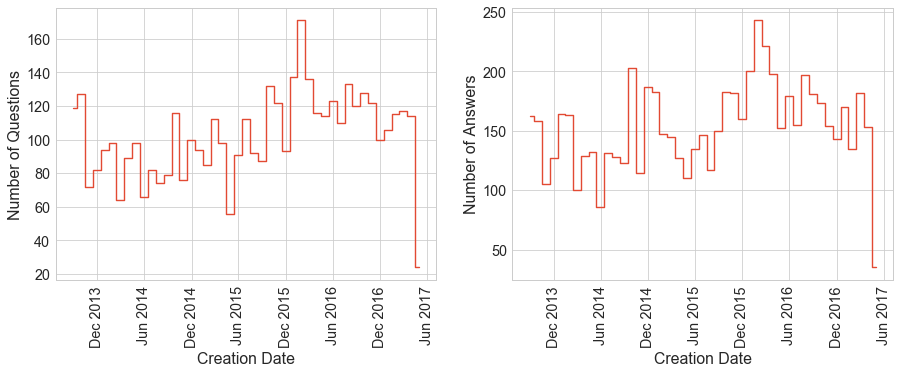

In [9]:
# Number of Questions
query = '''
SELECT CreationDate Post_date
FROM posts WHERE PostTypeId = 1 AND CreationDate < (SELECT DATETIME(MAX(CreationDate), '-720 HOURS') FROM posts )
ORDER BY 1
'''
Nquestion_df = pd.read_sql_query(query, conn)
Nquestion_df['Post_datein'] = pd.to_datetime(Nquestion_df['Post_date'])
Nquestion_df = Nquestion_df.resample('M', on="Post_datein").count()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15.0,5.0))
ax1.step(Nquestion_df.index, Nquestion_df['Post_datein'], where='mid')
labels = ['Dec 2013', 'Jun 2014', 'Dec 2014', 'Jun 2015', 'Dec 2015', 'Jun 2016', 'Dec 2016', 'Jun 2017']
ax1.set_xticklabels(labels,rotation=90)
ax1.set_xlabel('Creation Date')
ax1.set_ylabel('Number of Questions')

# Number of Answers

ans_query = '''
SELECT CreationDate Post_date
FROM posts WHERE PostTypeId = 2 AND CreationDate < (SELECT DATETIME(MAX(CreationDate), '-720 HOURS') FROM posts )
ORDER BY 1
'''
Nanswers_df = pd.read_sql_query(ans_query, conn)
Nanswers_df['Post_datein'] = pd.to_datetime(Nanswers_df['Post_date'])
Nanswers_df = Nanswers_df.resample('M', on="Post_datein").count()

ax2.step(Nanswers_df.index, Nanswers_df['Post_datein'], where='mid')
ax2.set_xticklabels(labels,rotation=90)
ax2.set_ylabel('Number of Answers')
ax2.set_xlabel('Creation Date')

print("\n")

## What fraction of Stack Overflow Astronomy question ends with a question mark?


In [10]:
sql_query='''SELECT ( CAST(COUNT(case when Title like '%?' then 1 end) AS FLOAT) / CAST(COUNT(*) AS FLOAT))
            * 100 as percent_questions FROM posts WHERE PostTypeId = 1'''

c.execute(sql_query)
print("\n"+str(c.fetchall()[0][0])+"% of Stack Overflow Astronomy questions end with a question mark.\n")


71.3860544218% of Stack Overflow Astronomy questions end with a question mark.



## Does adding a “?” to the Title actually help you to get answers?

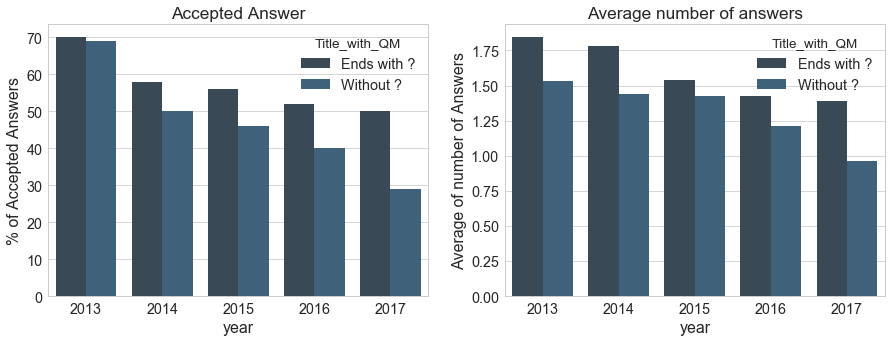

In [11]:
sql_query = '''
SELECT strftime('%Y', CreationDate) year, 
  case when Title LIKE '%?' then 'Ends with ?' else 'Without ?' end as Title_with_QM,
  ROUND(COUNT(AcceptedAnswerId)* 100/COUNT(*), 2) as AcceptedAnswer ,
  ROUND(AVG(AnswerCount), 3) as AvgAnswersCount 
FROM posts WHERE CreationDate < (SELECT DATETIME(MAX(CreationDate), '-720 HOURS') FROM posts ) AND posts.PostTypeId = 1
GROUP BY 1,2
ORDER BY 1,2
'''

title_df = pd.read_sql_query(sql_query, conn)

fig,[ax1,ax2] = plt.subplots(1,2, figsize=(15.0,5.0))
my_palette = sns.color_palette("Blues_d")
sns.barplot(x='year', y='AcceptedAnswer',hue='Title_with_QM', data=title_df, palette=my_palette, ax=ax1).set_title('Accepted Answer')
ax1.set_ylabel("% of Accepted Answers")
sns.barplot(x='year', y='AvgAnswersCount',hue='Title_with_QM', data=title_df, palette=my_palette, ax=ax2).set_title('Average number of answers')
ax2.set_ylabel("Average of number of Answers")
print("\n")

## Number of Question and Time answer V.S. Time

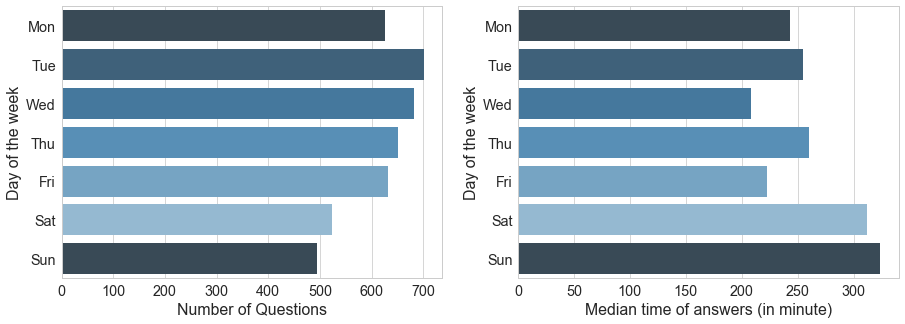

In [12]:
# In some posts the time difference between Posts and AcceptedAnswers is zero 
# and the AcceptedAnswer is posted by the same user who posts the question 

sql_query='''
SELECT  a.id as PostId, b.id as AnswerId, a.CreationDate Post_date, b.CreationDate Answer_date
FROM posts a
INNER JOIN posts b
ON a.Id = b.ParentId
ORDER BY 1 
'''
TimeAnswer = pd.read_sql_query(sql_query, conn)

TimeAnswer['Post_date'] = pd.to_datetime(TimeAnswer['Post_date'])
TimeAnswer['Answer_date'] = pd.to_datetime(TimeAnswer['Answer_date'])
TimeAnswer['Timediff_mn'] = (TimeAnswer['Answer_date'] - TimeAnswer['Post_date']).astype('timedelta64[m]')
# Find the time of the first answer
TimeAnswer = TimeAnswer.groupby(by='PostId',as_index=False).min()
# Find day of the week
TimeAnswer['DayWeek_i'] = TimeAnswer['Post_date'].dt.dayofweek
TimeAnswer['DayWeek'] = TimeAnswer['DayWeek_i'].map({0:'Mon', 1:'Tue',2:"Wed", 3:'Thu', 4:'Fri', 5:"Sat", 6:"Sun" })

# Number of Questions v.s day of week
dayweek_df = TimeAnswer.groupby(by='DayWeek',as_index=False).count()
dayweek1_df = TimeAnswer.groupby(by='DayWeek',as_index=False).median()
weekee=['Mon', 'Tue',"Wed", 'Thu', 'Fri', "Sat", "Sun"]

fig,[ax1,ax2] = plt.subplots(1,2, figsize=(15.0,5.0))
sns.barplot(x="PostId", y="DayWeek", data=dayweek_df, order=weekee,palette=my_palette, ax=ax1)
ax1.set_xlabel('Number of Questions')
ax1.set_ylabel('Day of the week')
sns.barplot(x="Timediff_mn", y="DayWeek", data=dayweek1_df, order=weekee,palette=my_palette, ax=ax2)
ax2.set_xlabel('Median time of answers (in minute)')
ax2.set_ylabel('Day of the week')
print("\n")

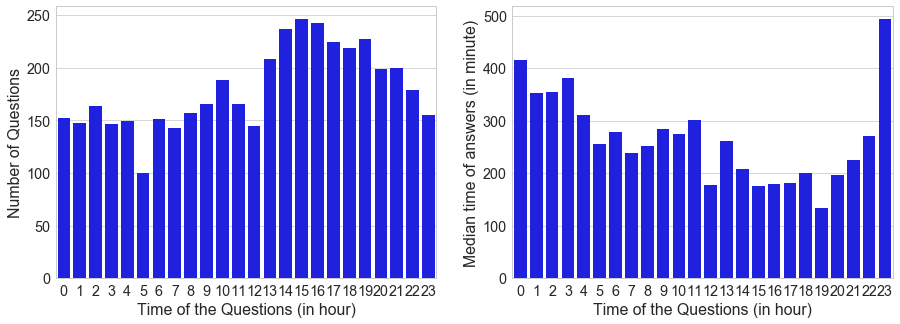

In [13]:
# Number of question and time of first answers as a function of the posted time (in hour)

TimeAnswer['hoursPost'] = TimeAnswer['Post_date'].dt.hour
hours_df = TimeAnswer.groupby(by='hoursPost',as_index=False).median()

fig,[ax1,ax2] = plt.subplots(1,2, figsize=(15.0,5.0))
sns.countplot(x="hoursPost", data=TimeAnswer, color='b', ax=ax1)
ax1.set_xlabel('Time of the Questions (in hour)')
ax1.set_ylabel('Number of Questions')
sns.barplot(x="hoursPost", y="Timediff_mn", data=hours_df, color='b', ax=ax2)
ax2.set_xlabel('Time of the Questions (in hour)')
ax2.set_ylabel('Median time of answers (in minute)')
print("\n")

## Most popular Tags

In [14]:
query = 'SELECT iD,Tags from posts where PosttypeId=1'
df = pd.read_sql_query(query, conn)
tags_dict={}
for tags in df['Tags'].values:
    tag = tags.split(',')
    for tagi in tag:
        if not tags_dict.has_key(tagi):
            tags_dict[tagi]=1
        else:
            tags_dict[tagi]+=1

Most_used_tags = sorted(tags_dict.items(), key=operator.itemgetter(1), reverse=True)
print('Top 5 most popular tags:')
for key,value in Most_used_tags[:5]: print("- "+key+"   ("+str(value)+")")

Top 5 most popular tags:
- star   (437)
- planet   (329)
- the-sun   (321)
- orbit   (309)
- the-moon   (283)


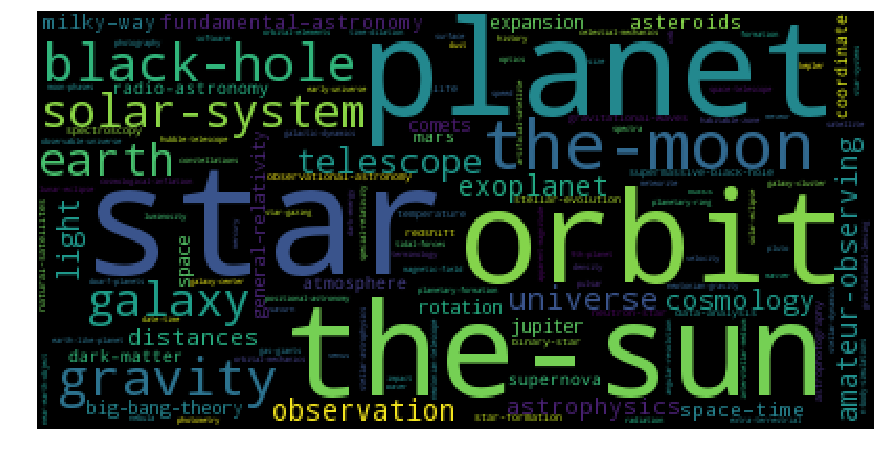

In [16]:
wordcloud = WordCloud().generate_from_frequencies(tags_dict)
plt.figure(figsize=(15.0,15.0))
plt.imshow(wordcloud)
plt.axis("off"); 
